## Covid-19 Data
Data obtained from the New York Times: 

https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv  
https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

Run all the cells below <b>IMPORTS AND FUNCTIONS</b> to refresh the data before refreshing the figures. 

             cases  deaths  new cases  new deaths
2020-04-19  753316   36109      25222        1383
2020-04-18  728094   34726      28241        1816
2020-04-17  699853   32910      31320        2187
2020-04-16  668533   30723      31477        2141
2020-04-15  637056   28582      29771        2502
2020-04-14  607285   26080      26432        2474
2020-04-13  580853   23606      25526        1551 



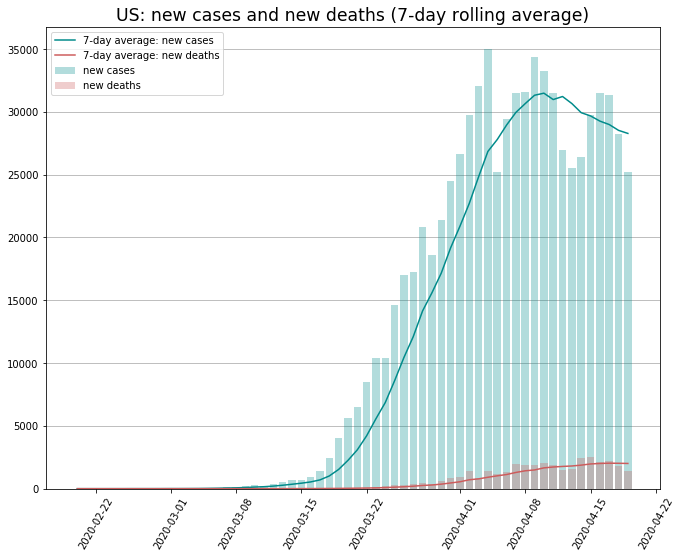

In [18]:
plot_rolling_means("US", True, 60, 7)

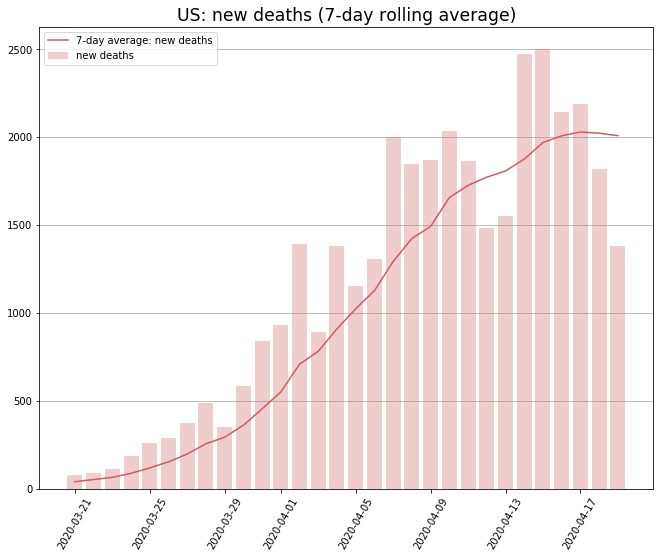

In [19]:
plot_rolling_deaths("US", True, 30, 7)

### Daily New Cases and Deaths

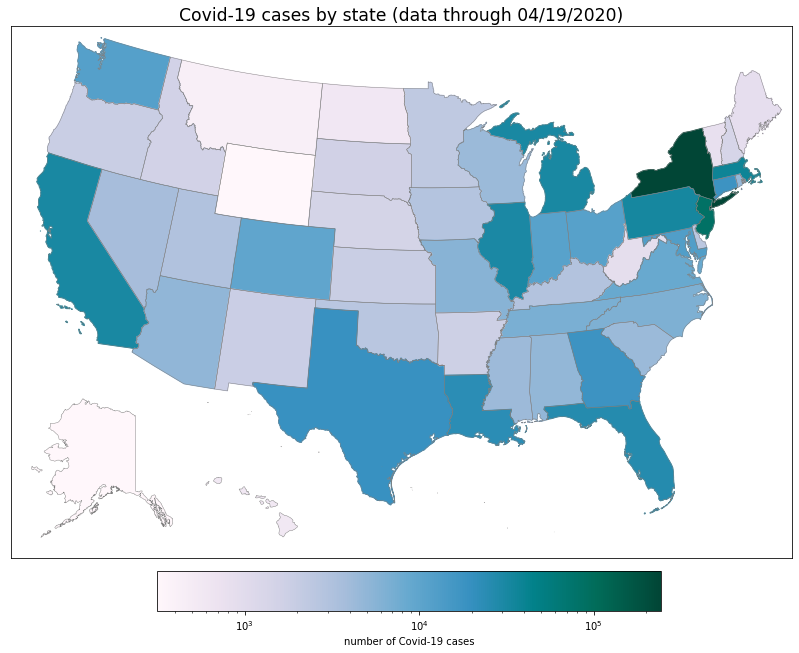

In [20]:
plot_cases_map()

### County + State Data 

In [28]:
region = "US"
data_asof, df = get_latest(region)
print("{} data through {}\n".format(region, str(data_asof)[:10]))
df.sort_values(by='cases', ascending=False, inplace=True)
df['CFR'] = df.deaths / df.cases * 100
df.cases = df.cases.apply(lambda x : "{:,}".format(x))
df.deaths = df.deaths.apply(lambda x : "{:,}".format(x))
df.CFR = df.CFR.apply(lambda x : "{:.2f}%".format(x))
df.index.name = None
print(df.head(n=10))

US data through 2020-04-19

                 cases  deaths    CFR
New York       242,817  13,869  5.71%
New Jersey      85,301   4,202  4.93%
Massachusetts   38,077   1,706  4.48%
Pennsylvania    32,992   1,285  3.89%
California      31,544   1,176  3.73%
Michigan        31,348   2,389  7.62%
Illinois        30,357   1,302  4.29%
Florida         26,306     773  2.94%
Louisiana       23,928   1,296  5.42%
Texas           19,443     503  2.59%


In [50]:
state = "Florida"
county = "Levy"

              state  cases  deaths  new cases  new deaths
2020-04-19  Florida 26,306     773        822          26
2020-04-18  Florida 25,484     747        739          22
2020-04-17  Florida 24,745     725      1,413          58
2020-04-16  Florida 23,332     667        806          54
2020-04-15  Florida 22,526     613        906          43
2020-04-14  Florida 21,620     570        609          72
2020-04-13  Florida 21,011     498      1,156          38 



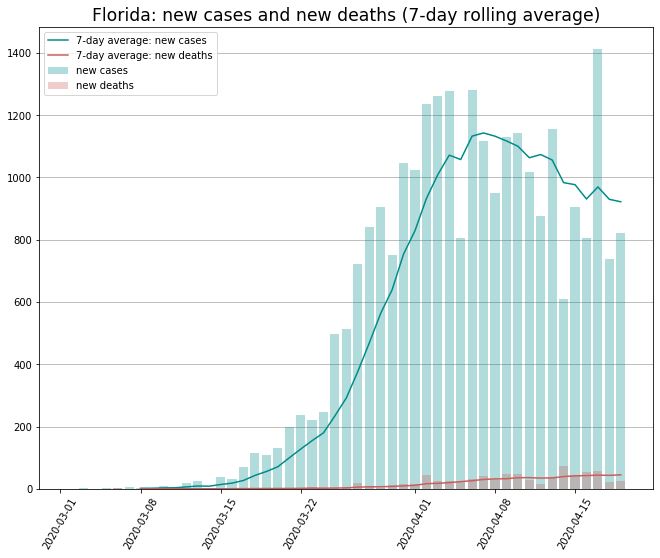

In [51]:
plot_rolling_means(state, True, 60, 7)

Levy County
2020-04-19 00:00:00: 12 cases, 0 deaths


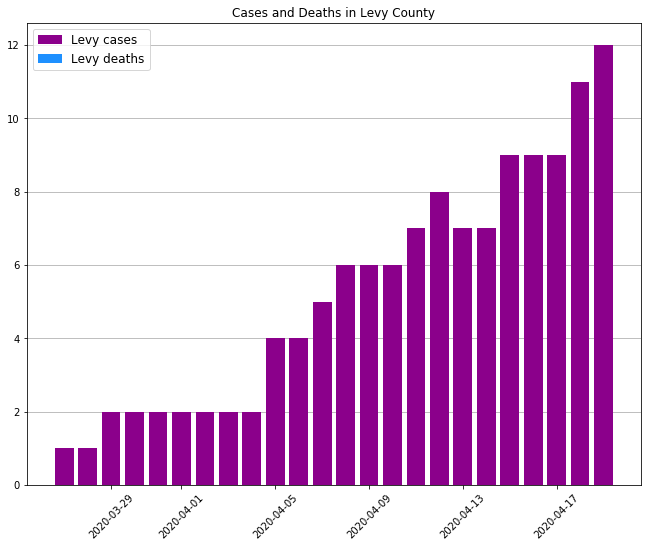

In [52]:
plot_county_cases(state, county, days=30)

### Case Fatality Ratio

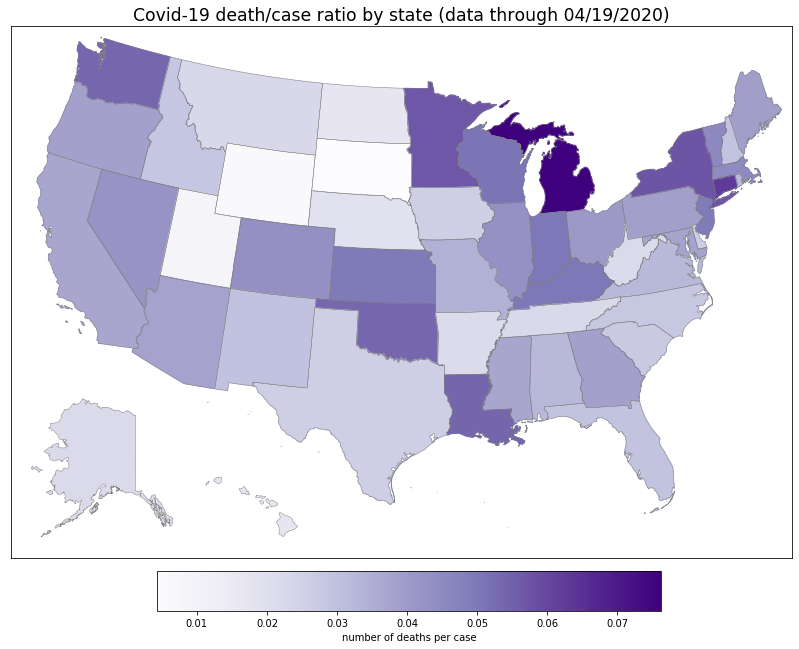

In [26]:
plot_cfr_map()

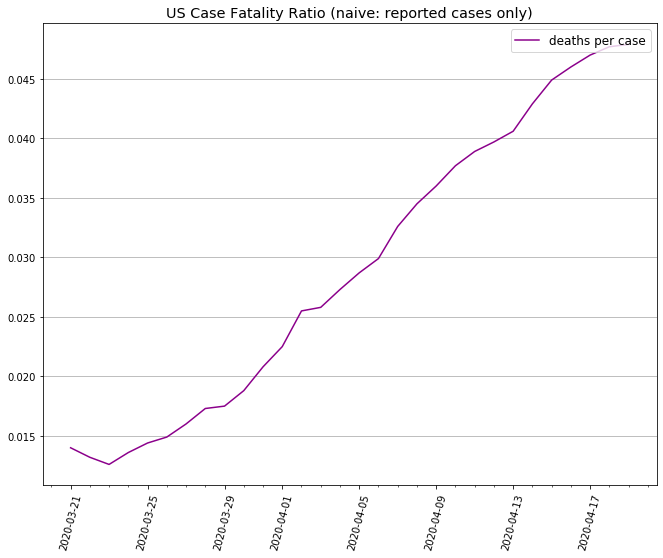

In [27]:
plot_cfr()

### IMPORTS AND FUNCTIONS
- Click on this cell, and then select <i>Cell > Run All Below</i> from the menu to import, refresh the data, and define the functions. 
- Next, click on this cell and select <i> Cell > Run All Above</i> to update the figures. 

In [2]:
import io
import pandas as pd
import numpy as np
import scipy as sp
import requests
import re
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import rgb2hex, Normalize, LogNorm
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
import os
import conda

%matplotlib inline

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

In [3]:
def get_data():
    url_counties = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
    url_states = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
    cdata = pd.read_csv(url_counties)
    sdata = pd.read_csv(url_states)
    sdata['date'] = pd.to_datetime(sdata['date'])
    
    # county data
    cdata.drop('fips', axis=1, inplace=True)
    cdata.set_index('date', inplace=True, drop=True)
    cdata.index.name = None
    cdata.sort_index(ascending=False, inplace=True)
    
    # state data
    sdata.drop('fips', axis=1, inplace=True)
    sdata.set_index('date', inplace=True, drop=True)
    sdata.index.name = None
    sdata.sort_index(ascending=False, inplace=True)
    
    # national data
    national = sdata.groupby(sdata.index)[['cases', 'deaths']].sum()
    national.index.name = None
    national['CFR'] = round(national['deaths'] / national['cases'], 4)
    national[['cases', 'deaths']] = national[['cases', 'deaths']].astype('int')
    
    # add columns for new cases and new deaths
    national.sort_index(ascending=False, inplace=True)
    national['new cases'] = national.cases - national.cases.shift(-1)
    national['new deaths'] = national.deaths - national.deaths.shift(-1)
    national.dropna(subset=['new cases', 'new deaths'], inplace=True)
    national[['new cases', 'new deaths']] = national[['new cases', 'new deaths']].astype('int')
    
    pd.options.display.float_format = '{:,.4f}'.format
    return national, sdata, cdata

In [4]:
national, sdata, cdata = get_data()

In [5]:
def get_latest(region="US"):
    if region in ['US', 'USA', 'United States']:
        latest = sdata.reset_index(drop=False)
        data_asof = latest.iloc[0]['index']
        latest = latest[latest['index'] == data_asof]
        latest.drop(columns='index', inplace=True)
        latest.set_index('state', drop=True, inplace=True)
        latest.sort_values(by='cases', ascending=False, inplace=True)
        return data_asof, latest
    else:
        latest = sdata[sdata.state == state]
        latest.sort_index(ascending=False, inplace=True)
        return latest.iloc[0]

In [6]:
def plot_rolling_means(region, show_bars=True, days=30, rolling_days=7):
    if region == 'US' or region == 'USA' or region == 'United States':
        df = national.copy()
        df.drop(columns='CFR', inplace=True)
    else:
        df = get_state_deltas(region)
        
    print(df.head(n=7), "\n")

    df.sort_index(ascending=True, inplace=True)
    df['rolling new cases'] = df['new cases'].rolling(rolling_days).mean()
    df['rolling new deaths'] = df['new deaths'].rolling(rolling_days).mean()
    df.sort_index(ascending=False, inplace=True)

    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    ax.plot(df.index[:days], 
            df['rolling new cases'].iloc[:days], 
            color='darkcyan', 
            label="{}-day average: new cases".format(rolling_days))
    ax.plot(df.index[:days], 
            df['rolling new deaths'].iloc[:days], 
            color='indianred', 
            label="{}-day average: new deaths".format(rolling_days))
    if show_bars:
        ax.bar(df.index[:days], 
               df['new cases'].iloc[:days], 
               color='darkcyan', alpha=0.3, 
               label='new cases')
        ax.bar(df.index[:days], 
               df['new deaths'].iloc[:days], 
               color='indianred', alpha=0.3, 
               label='new deaths')
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    plt.legend(loc=2, fontsize='medium')
    plt.xticks(rotation=60)
    plt.title("{}: new cases and new deaths ({}-day rolling average)"
              .format(region, rolling_days), fontsize='xx-large')
    plt.show()
    return

In [7]:
def plot_rolling_deaths(region, show_bars=True, days=30, rolling_days=7):
    if region == 'US' or region == 'USA' or region == 'United States':
        df = national.copy()
    else:
        df = get_state_deltas(region)

    df.sort_index(ascending=True, inplace=True)
    df['rolling new deaths'] = df['new deaths'].rolling(rolling_days).mean()
    df.sort_index(ascending=False, inplace=True)

    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    ax.plot(df.index[:days], df['rolling new deaths'].iloc[:days], 
            color='indianred', 
            label="{}-day average: new deaths".format(rolling_days))
    if show_bars:
        ax.bar(df.index[:days], 
               df['new deaths'].iloc[:days], 
               color='indianred', alpha=0.3, 
               label='new deaths')
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    plt.legend(fontsize='medium')
    plt.xticks(rotation=60)
    plt.title("{}: new deaths ({}-day rolling average)"
              .format(region, rolling_days), fontsize='xx-large')
    plt.show()
    return

In [8]:
def get_state_deltas(state_name, days=0):
    df = sdata.copy()
    df = df[df.state == state_name]
    df[['cases', 'deaths']] = df[['cases', 'deaths']].astype('float')
    df['new cases'] = df.cases - df.cases.shift(-1)
    df['new deaths'] = df.deaths - df.deaths.shift(-1)
    pd.options.display.float_format = '{:,.0f}'.format
    if days < 1:
        return df
    else:
        return df.iloc[:days]

In [9]:
def plot_daily_new_cases(state_name="US", days=30):
    if state_name == 'US' or state_name == "USA" or state_name == "United States":
        df = national.copy()
    else:
        df = get_state_deltas(state_name, days)
        
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    ax.plot(df.index[:days], df['new cases'].iloc[:days], color='darkcyan', label='new cases per day')
    ax.plot(df.index[:days], df['new deaths'].iloc[:days], color='indianred', label='new deaths per day')
    plt.xticks(rotation=60)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    plt.title("{}: new cases, new deaths per day".format(state_name), fontsize='xx-large')
    plt.legend(fontsize='large')
    plt.show()

In [10]:
def plot_us_cases(days=30):
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    ax.bar(national.index[:days], national.iloc[:days]['cases'], label="US cases", color='dodgerblue')
    ax.bar(national.index[:days], national.iloc[:days]['deaths'], label="US deaths", color='darkmagenta')
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, fontsize='medium')
    plt.title("US Cases and Deaths for Last %d Days" % days)
    plt.legend(loc=2, fancybox=True, fontsize='large')
    plt.show()

In [11]:
def plot_state_cases(state_name, days=30, labels=False):
    dfstate = sdata[sdata.state == state_name]
    dfstate.sort_index(ascending=False, inplace=True)

    latest = dfstate.iloc[-1]
    title = "Covid-19 Cases in {}".format(state_name)

    # plot state cases vs county cases
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    ax.bar(dfstate.index[:days], dfstate.iloc[:days]['cases'], 
           label="{} cases".format(state_name), color='darkcyan')     
    if labels:
        add_value_labels(ax, 3)
    ax.bar(dfstate.index[:days], dfstate.iloc[:days]['deaths'],
           label="{} deaths".format(state_name), color='darkslategrey')
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    plt.title(title)
    plt.xticks(rotation=45, fontsize='medium')
    plt.legend(loc=2, fancybox=True, fontsize='large')
    plt.show()

In [12]:
def plot_county_cases(state_name, county_name, days=30, labels=False):
    dfco = cdata[cdata['state'] == state_name]
    dfstate = sdata[sdata.state == state_name]
    dfstate.index = pd.to_datetime(dfstate.index)
    dfstate.sort_index(ascending=False, inplace=True)
    if county_name in dfco['county'].unique().tolist():
        coflag = 1
        dfco = dfco[dfco['county'] == county_name]
        dfco.index = pd.to_datetime(dfco.index)
        dfco.sort_index(ascending=False, inplace=True)
        latest = dfco.iloc[0]
        print(latest.county, "County")
        print("{}: {} cases, {} deaths".format(latest.name, latest.cases, latest.deaths))
        title = "County versus State Covid-19 Cases: {} County, {}".format(county_name, state_name)
    else: 
        print("County '{}' not found in state '{}'.".format(county_name, state_name))
        return

    # plot county cases vs deaths
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(11, 8.5)
    ax1.bar(dfco[dfco['county'] == county_name].index[:days], 
           dfco[dfco['county'] == county_name].iloc[:days]['cases'], 
           label='%s cases' % county_name, 
           color='darkmagenta')
    ax1.bar(dfco[dfco['county'] == county_name].index[:days], 
           dfco[dfco['county'] == county_name].iloc[:days]['deaths'], 
           label='%s deaths' % county_name, 
           color='dodgerblue')
    ax1.grid(axis='y')
    ax1.set_axisbelow(True)
    plt.title("Cases and Deaths in {} County".format(county_name))
    plt.xticks(rotation=45, fontsize='medium')
    plt.legend(loc=2, fancybox=True, fontsize='large')
    plt.show()

In [13]:
def add_value_labels(ax, spacing=5):
    for bar in ax.patches:
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        space = spacing
        va = 'bottom'

        if y_value < 0:
            space *= -1
            va = 'top'

        label = "{:.0f}".format(y_value)

        ax.annotate(
            label,                      
            (x_value, y_value),        
            xytext=(0, space),         
            textcoords="offset points", 
            ha='center', va=va)                      

In [14]:
def plot_cases_map():
    warnings.simplefilter('ignore') 
    data_asof, df = get_latest("US")
    df.drop(['American Samoa', 
         'Northern Mariana Islands', 
         'Virgin Islands', 'Guam', 
         'District of Columbia',
         'Puerto Rico'], axis=0, inplace=True)
    df.reset_index(drop=False, inplace=True)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 11)
    plt.title("Covid-19 cases by state (data through {})".format(
        data_asof.strftime("%m/%d/%Y")) , fontsize='xx-large')

    # basemap: contiguous
    m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
                projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # basemap: non-continguous
    m_ = Basemap(llcrnrlon=-190, llcrnrlat=20, urcrnrlon=-143, urcrnrlat=46, 
                projection='merc', lat_ts=20)

    # state boundaries from US Census Bureau
    ## http://www.census.gov/geo/www/cob/st2000.html
    shp_info = m.readshapefile('st99_d00','states',drawbounds=True,
                               linewidth=0.45,color='gray')
    shp_info_ = m_.readshapefile('st99_d00','states',drawbounds=False)

    colors={}
    statenames=[]
    cmap = plt.cm.PuBuGn 
    vmin = np.min(df.cases)
    vmax = np.max(df.cases)
    norm = LogNorm(vmin=vmin, vmax=vmax) 
    mapper = ScalarMappable(norm=norm, cmap=cmap)
    nodatacolor = 'lightgrey'
    nodatalegend = None

    # get data from df, put in color list
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        # skip DC and Puerto Rico.
        if statename not in ['District of Columbia','Puerto Rico']:
            if statename not in df['state'].unique().tolist():
                colors[statename] = nodatacolor
            cases = df[df.state == statename]['cases']
            colors[statename] = mapper.to_rgba(cases)
        statenames.append(statename)

    # color the states
    for nshape,seg in enumerate(m.states):
        # skip DC and Puerto Rico.
        if statenames[nshape] not in ['Puerto Rico', 'District of Columbia']:
            color = rgb2hex(colors[statenames[nshape]][0][:3])
            poly = Polygon(seg,facecolor=color,edgecolor=color)
            if (colors[statenames[nshape]] == nodatacolor):
                nodatalegend = poly
            ax.add_patch(poly)

    # adjust position/size of non-contiguous states to plot as insets
    THRESHOLD1 = 0.005              # exclude threshold for Hawaii
    THRESHOLD2 = THRESHOLD1 * 30.0  # exclude threshold for Alaska
    AK_SCALE = 0.2                  # scale down Alaska to show as a map inset
    HI_OFFSET_X = -1900000          # put AK and HI in main view
    HI_OFFSET_Y = 250000    
    AK_OFFSET_X = -250000   
    AK_OFFSET_Y = -750000   

    for nshape, shapedict in enumerate(m_.states_info):  
        if shapedict['NAME'] in ['Alaska', 'Hawaii']:
            seg = m_.states[int(shapedict['SHAPENUM'] - 1)]
            if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > THRESHOLD1:
                seg = [(x + HI_OFFSET_X, y + HI_OFFSET_Y) for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]][0][:3])
            elif shapedict['NAME'] == 'Alaska' and float(shapedict['AREA']) > THRESHOLD2:
                seg = [(x*AK_SCALE + AK_OFFSET_X, y * AK_SCALE + AK_OFFSET_Y)\
                       for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]][0][:3])
            poly = Polygon(seg, facecolor=color, edgecolor='gray', linewidth=.45)
            ax.add_patch(poly)

    # if any states with no data, add legend
    if nodatalegend is not None:
        plt.legend((nodatalegend,), ('no reported cases',))

    # colorbar
    cax = fig.add_axes([0.27, 0.1, 0.5, 0.05]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    cb.ax.set_xlabel('number of Covid-19 cases')

    plt.show()

In [15]:
def plot_cfr(days=30):
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    ax.plot(national.index[:days], national.iloc[:days]['CFR'], label='deaths per case', color='darkmagenta')
    plt.title("US Case Fatality Ratio (naive: reported cases only)", fontsize='x-large')
    plt.xticks(rotation=75)
    plt.legend(loc=1, fancybox=True, fontsize='large')
    ax.grid(axis='y')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_axisbelow(True)
    plt.show()

In [16]:
def plot_cfr_map():
    warnings.simplefilter('ignore') 
    
    data_asof, df = get_latest("US")
    df['CFR'] = df.deaths / df.cases
    df.drop(['American Samoa', 
         'Northern Mariana Islands', 
         'Virgin Islands', 'Guam', 
         'District of Columbia',
         'Puerto Rico'], axis=0, inplace=True)
    df.reset_index(drop=False, inplace=True)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 11)
    plt.title("Covid-19 death/case ratio by state (data through {})".format(
        data_asof.strftime("%m/%d/%Y")) , fontsize='xx-large')

    # basemap: contiguous
    m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
                projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # basemap: non-continguous
    m_ = Basemap(llcrnrlon=-190, llcrnrlat=20, urcrnrlon=-143, urcrnrlat=46, 
                projection='merc', lat_ts=20)

    # state boundaries from US Census Bureau
    ## http://www.census.gov/geo/www/cob/st2000.html
    shp_info = m.readshapefile('st99_d00','states',drawbounds=True,
                               linewidth=0.45,color='gray')
    shp_info_ = m_.readshapefile('st99_d00','states',drawbounds=False)

    colors={}
    statenames=[]
    cmap = plt.cm.Purples 
    vmin = np.min(df.CFR)
    vmax = np.max(df.CFR)
    norm = Normalize(vmin=vmin, vmax=vmax) 
    mapper = ScalarMappable(norm=norm, cmap=cmap)
    nodatacolor = 'lightgrey'
    nodatalegend = None

    # get data from df, put in color list
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        # skip DC and Puerto Rico.
        if statename not in ['District of Columbia','Puerto Rico']:
            if statename not in df['state'].unique().tolist():
                colors[statename] = nodatacolor
            ratio = df[df.state == statename]['CFR']
            colors[statename] = mapper.to_rgba(ratio)
        statenames.append(statename)

    # color the states
    for nshape,seg in enumerate(m.states):
        # skip DC and Puerto Rico.
        if statenames[nshape] not in ['Puerto Rico', 'District of Columbia']:
            color = rgb2hex(colors[statenames[nshape]][0][:3])
            poly = Polygon(seg,facecolor=color,edgecolor=color)
            if (colors[statenames[nshape]] == nodatacolor):
                nodatalegend = poly
            ax.add_patch(poly)

    # adjust position/size of non-contiguous states to plot as insets
    THRESHOLD1 = 0.005              # exclude threshold for Hawaii
    THRESHOLD2 = THRESHOLD1 * 30.0  # exclude threshold for Alaska
    AK_SCALE = 0.2                  # scale down Alaska to show as a map inset
    HI_OFFSET_X = -1900000          # put AK and HI in main view
    HI_OFFSET_Y = 250000    
    AK_OFFSET_X = -250000   
    AK_OFFSET_Y = -750000   

    for nshape, shapedict in enumerate(m_.states_info):  
        if shapedict['NAME'] in ['Alaska', 'Hawaii']:
            seg = m_.states[int(shapedict['SHAPENUM'] - 1)]
            if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > THRESHOLD1:
                seg = [(x + HI_OFFSET_X, y + HI_OFFSET_Y) for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]][0][:3])
            elif shapedict['NAME'] == 'Alaska' and float(shapedict['AREA']) > THRESHOLD2:
                seg = [(x*AK_SCALE + AK_OFFSET_X, y * AK_SCALE + AK_OFFSET_Y)\
                       for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]][0][:3])
            poly = Polygon(seg, facecolor=color, edgecolor='gray', linewidth=.45)
            ax.add_patch(poly)

    # if any states with no data, add legend
    if nodatalegend is not None:
        plt.legend((nodatalegend,), ('no reported cases',))

    # colorbar
    cax = fig.add_axes([0.27, 0.1, 0.5, 0.05]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    cb.ax.set_xlabel('number of deaths per case')

    plt.show()

In [17]:
def plot_top_state_growth(days=30):
    plot_states = sdata[sdata['date'] == data_asof].sort_values('cases', ascending=False).iloc[:10]['state'].tolist()
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for st in plot_states:
        x = sdata[sdata['state'] == st].sort_values('date', ascending=True).iloc[:days]['date']
        y = sdata[sdata['state'] == st].sort_values('date', ascending=True).iloc[:days]['cases']
        ax.plot(x, y, label='%s cases' % st, color=colors[plot_states.index(st)])

    plt.legend(loc=2, fancybox=True)
    plt.title("US states with most cases")
    plt.xticks(rotation=70)
    plt.show()